In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

drqn_csv = pd.read_csv("drqn_test_log.csv")
dqn_csv = pd.read_csv("dqn_test_log.csv")
offload_csv = pd.read_csv("offload_only_test_log.csv")
local_csv = pd.read_csv("local_only_test_log.csv")

drqn = drqn_csv[drqn_csv["epoch"]==19]["reward"]
dqn = dqn_csv[dqn_csv["epoch"]==19]["reward"]
offload = offload_csv[offload_csv["epoch"]==19]["reward"]
local = local_csv[local_csv["epoch"]==19]["reward"]

DRQN mean:  305.6455
DQN mean:  289.6215
Offload mean:  54.230000000000004
Local mean:  243.175


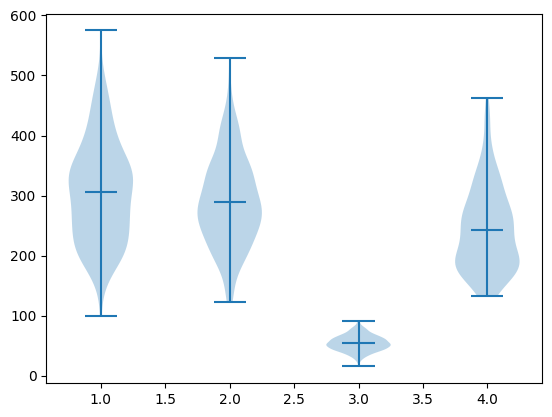

In [2]:
fig, ax = plt.subplots()
violin = ax.violinplot([drqn, dqn, offload, local], showmeans=True)
# Print the mean of each model
print("DRQN mean: ", np.mean(drqn))
print("DQN mean: ", np.mean(dqn))
print("Offload mean: ", np.mean(offload))
print("Local mean: ", np.mean(local))

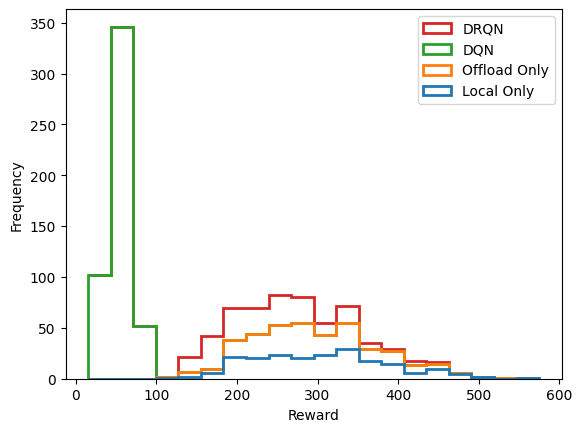

In [3]:
fig, ax = plt.subplots()
# Draw histogram with outline of the bars
n, bins, patches = ax.hist([drqn, dqn, offload, local], bins=20, histtype='step', linewidth=2, stacked=True)
ax.legend(["DRQN", "DQN", "Offload Only", "Local Only"])
ax.set_xlabel("Reward")
ax.set_ylabel("Frequency")
plt.show()


In [5]:
# For DRQN, I would like to know the ratio of offload to local with regard to whether the channel is good or bad
# For DQN, I would like to know the ratio of offload to local with regard to whether the channel is good or bad

print("DRQN when channel is 0")
# Count the number of times both action = 0 and channel_quality = 0
print(len(drqn_csv[(drqn_csv["action"]==0) & (drqn_csv["channel_quality"]==0)]) / len(drqn_csv[drqn_csv["channel_quality"]==0]))
# Count the number of times both action = 1 and channel_quality = 0
print(len(drqn_csv[(drqn_csv["action"]==1) & (drqn_csv["channel_quality"]==0)]) / len(drqn_csv[drqn_csv["channel_quality"]==0]))
# Count the number of times both action = 0 and channel_quality = 1
print(len(drqn_csv[(drqn_csv["action"]==0) & (drqn_csv["channel_quality"]==1)]) / len(drqn_csv[drqn_csv["channel_quality"]==1]))
# Count the number of times both action = 1 and channel_quality = 1
print(len(drqn_csv[(drqn_csv["action"]==1) & (drqn_csv["channel_quality"]==1)]) / len(drqn_csv[drqn_csv["channel_quality"]==1]))

print("DQN when channel is 0")
# Count the number of times both action = 0 and channel_quality = 0
print(len(dqn_csv[(dqn_csv["action"]==0) & (dqn_csv["channel_quality"]==0)]) / len(dqn_csv[dqn_csv["channel_quality"]==0]))
# Count the number of times both action = 1 and channel_quality = 0
print(len(dqn_csv[(dqn_csv["action"]==1) & (dqn_csv["channel_quality"]==0)]) / len(dqn_csv[dqn_csv["channel_quality"]==0]))
# Count the number of times both action = 0 and channel_quality = 1
print(len(dqn_csv[(dqn_csv["action"]==0) & (dqn_csv["channel_quality"]==1)]) / len(dqn_csv[dqn_csv["channel_quality"]==1]))
# Count the number of times both action = 1 and channel_quality = 1
print(len(dqn_csv[(dqn_csv["action"]==1) & (dqn_csv["channel_quality"]==1)]) / len(dqn_csv[dqn_csv["channel_quality"]==1]))


DRQN when channel is 0
0.5391449194891726
0.4608550805108273
0.55025011368804
0.44974988631196
DQN when channel is 0
0.6506550218340611
0.34934497816593885
0.6577490774907749
0.3422509225092251
